In this document, four parameter estimation techniques are presented, applied on models of interest in population dynamics: 1) exponential growth, 2) logistic growth, 3) Classic Lotka-Volterra (predator-prey, two populations), and 4) Generalized Lotka-Volterra with $n>2$ populations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import integrate
from scipy import optimize
from scipy import interpolate

def exp_equation(t, x, *args):
    r = args[0]
    return r * x

def log_equation(t, x, *args):
    r = args[0]
    a = args[1]
    return x * (r + a*x)

def lv_equation(t, x, *args):
    r = np.array(args[0:2])
    b = np.array([list(args[2:4]), list(args[4:6])])
    return x * (r + b @ x)  # x_i = x_i (r_i + \sum b_ij x_j)

def add_noise(data, sigma):
    return data + np.random.normal(scale=sigma, size=np.shape(data))

def clean_data(data, eps):
    data[data < eps] = 0
    return data


# Exponential growth

## Data generation with given parameters

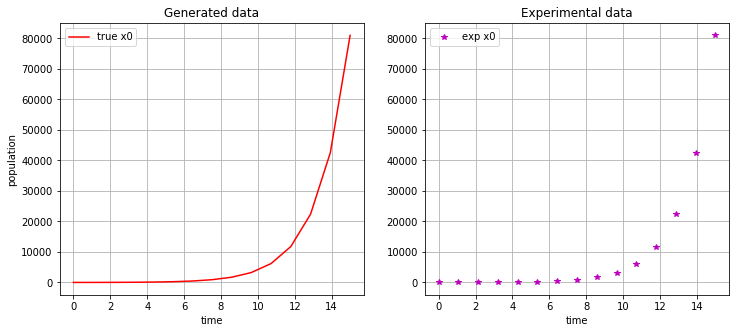

In [49]:
###################################################################################################
### Definition of variables
###################################################################################################

# ODE parameters
r = 0.6                 # Rate of growth
params = (r,)

# Additional conditions
x0 = np.array([10])     # Initial population
t0 = 0                  # Time evaluation starting point
tf = 15                 # Time evaluation finishing point

# Time points to be displayed
num_tpoints = 15
t_points = np.linspace(t0, tf, num_tpoints)

###################################################################################################
### Data generation
###################################################################################################

sigma = num_tpoints**-0.5
eps = 1E-4

sol_exp = integrate.solve_ivp(exp_equation, (t0,tf), x0, args=params, t_eval=t_points)
data_exp = add_noise(sol_exp.y, sigma)
data_exp = clean_data(data_exp, eps)

###################################################################################################
### Display
###################################################################################################
# print(sol_lv.message)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
ax0.plot(t_points, sol_exp.y[0], '-r', label='true x0')
ax0.set_title('Generated data')
ax0.set_ylabel('population')
ax0.set_xlabel('time')
ax0.legend(loc='best')
ax0.grid()
ax1.plot(t_points, data_exp[0], 'm*', label='exp x0')
ax1.set_title('Experimental data')
ax1.set_xlabel('time')
ax1.legend(loc='best')
ax1.grid()
plt.show()

## Parameter estimation

We first do...

### Nonlinear least squares or Trajectory matching

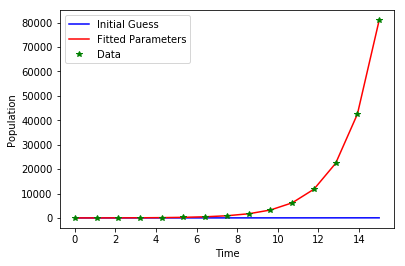

In [50]:
def exp_residuals(params):
    sim_data = integrate.solve_ivp(exp_equation, (t0,tf), x0, args=params, t_eval=t_points)
    return sim_data.y[0] - data_exp[0]

initial_params = (0.1,)
fitted_params = optimize.least_squares(exp_residuals, initial_params, method='lm')

initial_guess = integrate.solve_ivp(exp_equation, (t0,tf), x0, args=initial_params, t_eval=t_points)
fitted_data = integrate.solve_ivp(exp_equation, (t0,tf), x0, args=fitted_params.x, t_eval=t_points)

plt.plot(t_points, initial_guess.y[0], 'b-', label='Initial Guess')
plt.plot(t_points, fitted_data.y[0], 'r-', label='Fitted Parameters')
plt.plot(t_points, data_exp[0], 'g*', label='Data')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

### Gradient matching

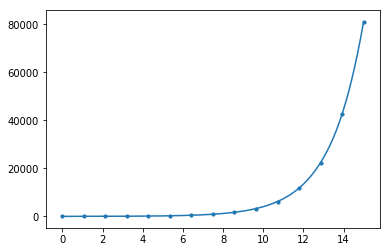

In [36]:
cs0 = interpolate.CubicSpline(t_points, sol_exp.y[0])
tnew = np.linspace(t0, tf, 500)

plt.plot(tnew,cs0(tnew), label='interpolated x0')
plt.scatter(t_points, data_exp[0], s=10, label='x0')
plt.show()

### Parameter cascading

# Logistic growth

## Data generation with given parameters

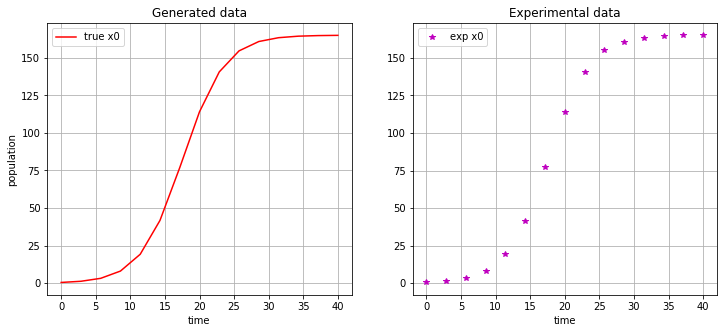

In [105]:
###################################################################################################
### Declaration of variables 
###################################################################################################

# ODE parameters
r = 0.33    # Rate of growth
a = -0.002    # 
params = (r, a)

# Additional conditions
x0 = np.array([0.5])     # Initial population
t0 = 0                   # Time evaluation starting point
tf = 40                  # Time evaluation finishing point

# Time points to be displayed
num_tpoints = 15
t_points = np.linspace(t0, tf, num_tpoints)

###################################################################################################
### Data generation
###################################################################################################

sigma = num_tpoints**-0.5    # Standard deviation of noise
eps = 1E-4                   # Data below this value will be set to zero

sol_log = integrate.solve_ivp(log_equation, (t0,tf), x0, args=params, t_eval=t_points)
data_log = add_noise(sol_log.y, sigma)
data_log = clean_data(data_log, eps)

###################################################################################################
### Display
###################################################################################################
# print(sol_lv.message)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
ax0.plot(t_points, sol_log.y[0], '-r', label='true x0')
ax0.set_title('Generated data')
ax0.set_ylabel('population')
ax0.set_xlabel('time')
ax0.legend(loc='best')
ax0.grid()
ax1.plot(t_points, data_log[0], 'm*', label='exp x0')
ax1.set_title('Experimental data')
ax1.set_xlabel('time')
ax1.legend(loc='best')
ax1.grid()
plt.show()


def plot_solution(t_points, sol):
    plt.plot(t_points, sol_log.y[0], '-r', label='x0')
    plt.grid()
    plt.legend(loc='best')
    plt.ylabel('population')
    plt.xlabel('time')
    plt.show()

## Parameter estimation

### Linear least squares

(0.31530324451957004, -0.001965881454793833)


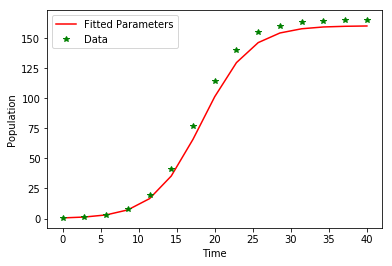

In [106]:
b = np.zeros(num_tpoints)
A = np.zeros((num_tpoints,2))
for i in range(num_tpoints-1):
    b[i] = np.log(data_log[0,i+1]/data_log[0,i])/(t_points[i+1]-t_points[i])
    A[i] = [1, data_log[0,i]]
    
reg = optimize.lsq_linear(A, b, lsq_solver='lsmr')
fitted_params = tuple(reg.x)

fitted_data = integrate.solve_ivp(log_equation, (t0,tf), x0, args=fitted_params, t_eval=t_points)
fitted_data = fitted_data.y.flatten()

print(fitted_params)
plt.plot(t_points, fitted_data, 'r-', label='Fitted Parameters')
plt.plot(t_points, data_log[0], 'g*', label='Data')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

### Trajectory matching

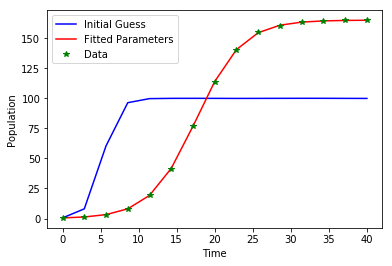

In [107]:
def log_residuals(params):
    sim_data = integrate.solve_ivp(log_equation, (t0,tf), x0, args=params, t_eval=t_points)
    return sim_data.y[0] - data_log[0]

initial_params = (1, -0.01)
fitted_params = optimize.least_squares(log_residuals, initial_params, method='lm')

initial_guess = integrate.solve_ivp(log_equation, (t0,tf), x0, args=initial_params, t_eval=t_points)
fitted_data = integrate.solve_ivp(log_equation, (t0,tf), x0, args=fitted_params.x, t_eval=t_points)

plt.plot(t_points, initial_guess.y[0], 'b-', label='Initial Guess')
plt.plot(t_points, fitted_data.y[0], 'r-', label='Fitted Parameters')
plt.plot(t_points, data_log[0], 'g*', label='Data')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

### Gradient matching

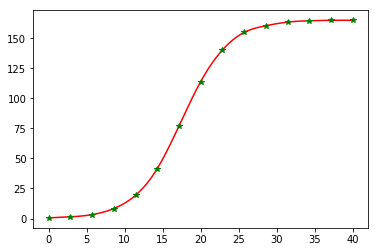

In [108]:
cs0 = interpolate.CubicSpline(t_points, data_log[0])
tnew = np.linspace(t0, tf, 500)

plt.plot(tnew,cs0(tnew), 'r-', label='interpolated x0')
plt.plot(t_points, data_log[0], 'g*', label='x0')
plt.show()

### Parameter cascading

# Lotka-Volterra

## Data generation

(1.0, -1.5, 0.0, -0.3, 0.7, 0.0)


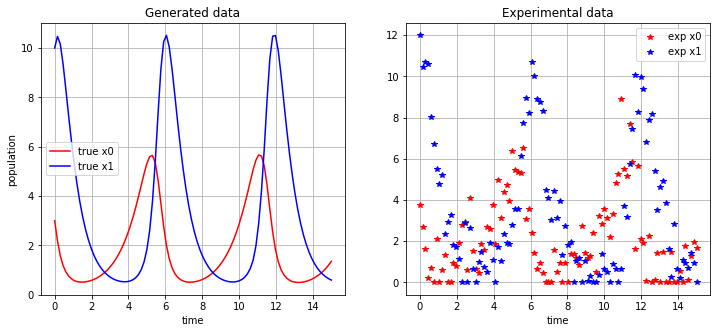

In [57]:
###################################################################################################
### Declaration of variables
###################################################################################################

# ODE Parameters
r = np.array([1,-1.5])
b = np.array([[0,-0.3],[0.7,0]])
params = tuple(i for i in r) + tuple(j for j in b.flatten())

# Additional conditions
t0 = 0      # Time evaluation starting point
tf = 15     # Time evaluation finishing point
x0 = np.array([3,10])

# Time points to be displayed
num_tpoints = 100
t_points = np.linspace(t0, tf, num_tpoints)

###################################################################################################
### Data generation
###################################################################################################

sigma = 1
eps = 1E-4

sol_lv = integrate.solve_ivp(lv_equation, (t0,tf), x0, args=params, t_eval=t_points)
data_lv = add_noise(sol_lv.y, sigma)
data_lv = clean_data(data_lv, eps)

###################################################################################################
### Display
###################################################################################################

# print(sol_lv.message)
print(params)
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
ax0.plot(t_points, sol_lv.y[0], '-r', label='true x0')
ax0.plot(t_points, sol_lv.y[1], '-b', label='true x1')
ax0.set_title('Generated data')
ax0.set_ylabel('population')
ax0.set_xlabel('time')
ax0.legend(loc='best')
ax0.grid()
ax1.plot(t_points, data_lv[0], 'r*', label='exp x0')
ax1.plot(t_points, data_lv[1], 'b*', label='exp x1') 
ax1.set_title('Experimental data')
ax1.set_xlabel('time')
ax1.legend(loc='best')
ax1.grid()
plt.show()

## Parameter estimation

### Linear least squares

[ 1.04767485 -0.28607518]
(1.0476748546418673, -1.3747401130635564, 0, -0.2860751779825109, 0.5247194960077397, 0)


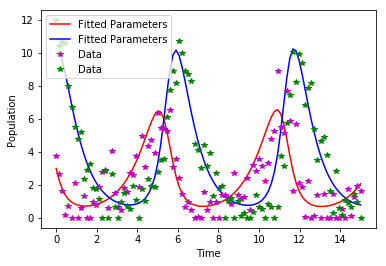

In [58]:
b1 = np.zeros(num_tpoints)
b2 = np.zeros(num_tpoints)
A1 = np.zeros((num_tpoints, 2))
A2 = np.zeros((num_tpoints, 2))
A1[:,0] = np.ones(num_tpoints)
A2[:,0] = np.ones(num_tpoints)
for i in range(num_tpoints-1):
    if data_lv[0,i+1]==0 or data_lv[0,i]==0:
        b1[i] = 0
    else:
        b1[i] = np.log(data_lv[0,i+1]/data_lv[0,i])/(t_points[i+1]-t_points[i])
    if data_lv[1,i+1]==0 or data_lv[1,i]==0:
        b2[1] = 0
    else:
        b2[i] = np.log(data_lv[1,i+1]/data_lv[1,i])/(t_points[i+1]-t_points[i])
    A1[i,1] = data_lv[1,i]
    A2[i,1] = data_lv[0,i]

reg1 = optimize.lsq_linear(A1, b1, lsq_solver='lsmr')    # returns (r1, b11, b12)
reg2 = optimize.lsq_linear(A2, b2, lsq_solver='lsmr')    # returns (r2, b21, b22)

fitted_params = (reg1.x[0],) + (reg2.x[0],) + (0,) + (reg1.x[1],) + (reg2.x[1],) + (0,)

print(reg1.x)
print(fitted_params)

fitted_data = integrate.solve_ivp(lv_equation, (t0,tf), x0, args=fitted_params, t_eval=t_points)

plt.plot(t_points, fitted_data.y[0], 'r-', label='Fitted Parameters')
plt.plot(t_points, fitted_data.y[1], 'b-', label='Fitted Parameters')
plt.plot(t_points, data_lv[0], 'm*', label='Data')
plt.plot(t_points, data_lv[1], 'g*', label='Data')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

In [147]:
a = [1, 3, 4]
b = [2, 5, 6]
a+b

[1, 3, 4, 2, 5, 6]

### Trajectory matching

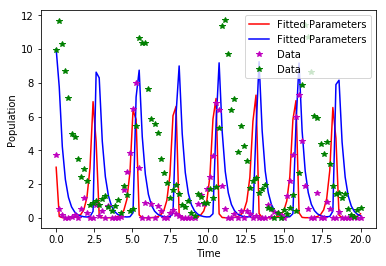

In [152]:
def lv_residuals(params):
    sim_data = integrate.solve_ivp(lv_equation, (t0,tf), x0, args=params, t_eval=t_points)
    return sim_data.y[0] - data_lv[0] + sim_data.y[1] - data_lv[1]

initial_r = np.array([5,-3])
initial_b = np.array([[0,-2],[3,0]])
initial_params = tuple(i for i in initial_r) + tuple(j for j in initial_b.flatten())
fitted_params = optimize.least_squares(lv_residuals, initial_params)

initial_guess = integrate.solve_ivp(lv_equation, (t0,tf), x0, args=initial_params, t_eval=t_points)
fitted_data = integrate.solve_ivp(lv_equation, (t0,tf), x0, args=fitted_params.x, t_eval=t_points)

#plt.plot(t_points, initial_guess.y[0], 'b-', label='Initial Guess')
#plt.plot(t_points, initial_guess.y[1], 'b-', label='Initial Guess')
plt.plot(t_points, fitted_data.y[0], 'r-', label='Fitted Parameters')
plt.plot(t_points, fitted_data.y[1], 'b-', label='Fitted Parameters')
plt.plot(t_points, data_lv[0], 'm*', label='Data')
plt.plot(t_points, data_lv[1], 'g*', label='Data')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()


# lm_fit

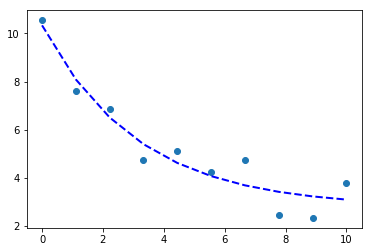

In [189]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

def f(xs, t, ps):
    """Receptor synthesis-internalization model."""
    try:
        a = ps['a'].value
        b = ps['b'].value
    except:
        a, b = ps
    x = xs

    return a - b*x

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    x0 = ps['x0'].value
    model = g(ts, x0, ps)
    return (model - data).ravel()

a = 2.0
b = 0.5
true_params = [a, b]
x0 = 10.0

t = np.linspace(0, 10, 10)
data = g(t, x0, true_params)
data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('x0', value=float(data[0]), min=0, max=100)
params.add('a', value= 9.0, min=0, max=10)
params.add('b', value= 9.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
plt.plot(t, data, 'o')
plt.plot(t, final, '--', linewidth=2, c='blue');

# display fitted statistics
# report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 89
    # data points      = 200
    # variables        = 6
    chi-square         = 184.624243
    reduced chi-square = 0.95167135
    Akaike info crit   = -3.99894552
    Bayesian info crit = 15.7909587
[[Variables]]
    x0:  0.86847170 +/- 0.15394768 (17.73%) (init = 0.8515674)
    y0:  0.96891673 +/- 0.09631050 (9.94%) (init = 0.1368585)
    a:   3.30657605 +/- 0.39445531 (11.93%) (init = 5)
    b:   1.11406099 +/- 0.12699242 (11.40%) (init = 3)
    c:   0.99634714 +/- 0.08605977 (8.64%) (init = 3)
    d:   0.94823644 +/- 0.08599784 (9.07%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)   =  0.961
    C(a, d)   = -0.955
    C(b, d)   = -0.876
    C(x0, b)  = -0.804
    C(x0, a)  = -0.792
    C(y0, c)  = -0.682
    C(y0, d)  = -0.678
    C(x0, d)  =  0.634
    C(c, d)   =  0.618
    C(a, c)   = -0.484
    C(y0, a)  =  0.468
    C(b, c)   = -0.385
    C(y0, b)  =  0.263
    C(x0

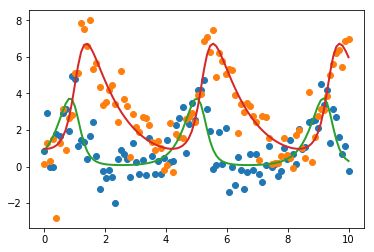

In [191]:
def f(xs, t, ps):
    """Lotka-Volterra predator-prey model."""
    try:
        a = ps['a'].value
        b = ps['b'].value
        c = ps['c'].value
        d = ps['d'].value
    except:
        a, b, c, d = ps

    x, y = xs
    return [a*x - b*x*y, c*x*y - d*y]

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    x0 = ps['x0'].value, ps['y0'].value
    model = g(ts, x0, ps)
    return (model - data).ravel()

t = np.linspace(0, 10, 100)
x0 = np.array([1,1])

a, b, c, d = 3,1,1,1
true_params = np.array((a, b, c, d))
data = g(t, x0, true_params)
data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('x0', value= float(data[0, 0]), min=0, max=10)
params.add('y0', value=float(data[0, 1]), min=0, max=10)
params.add('a', value=5.0, min=0, max=10)
params.add('b', value=3.0, min=0, max=10)
params.add('c', value=3.0, min=0, max=10)
params.add('d', value=3.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
plt.plot(t, data, 'o')
plt.plot(t, final, '-', linewidth=2);

# display fitted statistics
report_fit(result)

### Gradient matching

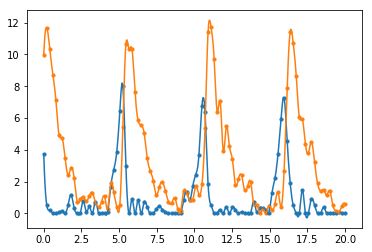

In [155]:
cs0 = interpolate.CubicSpline(t_points, data_lv[0])
cs1 = interpolate.CubicSpline(t_points, data_lv[1])
tnew = np.linspace(t0, tf, 500)

plt.plot(tnew,cs0(tnew), label='interpolated x0')
plt.plot(tnew,cs1(tnew), label='interpolated x1')
plt.scatter(t_points, data_lv[0], s=10, label='x0')
plt.scatter(t_points, data_lv[1], s=10, label='x1') 
plt.show()

### Parameter cascading

### Something else